# Gaussian Mixture Model

### Imports

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Motivating GMM: Weakness of k-means

k-means does simple clustering that humans can do with their eyes

In [61]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers=4, cluster_std=0.6, random_state=1)

X = X[:, ::-1] #We flip the axes to allow better plotting

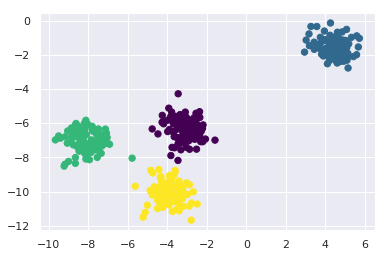

In [62]:
# plot the data with K Means Labels
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=42)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis')

Some clusterings are more obvious than others. There's almost a slight overlap between the purple and yellow clusters. Moreover, we have a point that's part of the green cluster that's somewhat in the middle of the bottom three clusters. 


### Certainty

k-means doesn't intrinsically measure the probability or certainty of it's clustering. To overcome this, we must find a method to generalize our model. 


In [63]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed = 0, ax=None):
    labels = kmeans.fit_predict(X)
    
    #plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
    
    #plot the representation of the Kmeans model
    centers = kmeans.cluster_centers_
    #the radius of the furthers point
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
             ax.add_patch(plt.Circle(c,r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

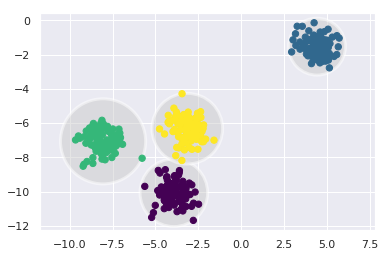

In [64]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans,X)

### Non-circular clusters

K-means figures out the clusters by drawing a circle around the mean cetroid, so it's unable to work with oblong or elliptical data

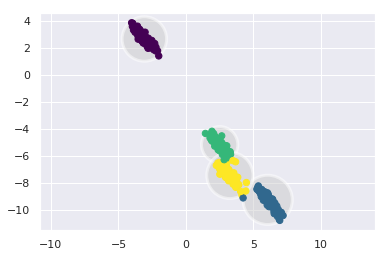

In [65]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

That blue dot clearly belongs to the yellow cluster but the circular model can't capture that

## Generalizing E-M: Guassian Mixture Models

Two problems that are addressed by the Gaussian Mixture Model (GMM)

The GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that nest model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

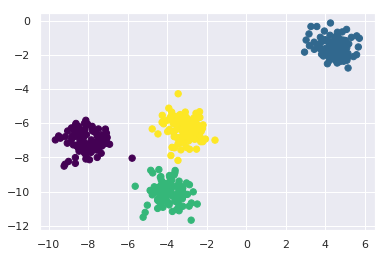

In [66]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis');

However, since GMM contains a probabilistic model, it is also possible to find probabilistic cluster assignments - in Scikit-Learn this is done using the `predict_proba` method.

This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [67]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.139 0.861]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]]


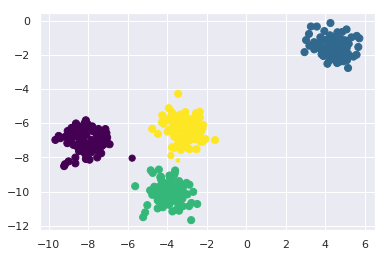

In [68]:
size = 50*probs.max(1)**2 #squares emphasize differences
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=size)

Apparently it's pretty sure that that lone purple dot belongs to the purple cluster, less so for the bottom most green dot 

### EM Algorithm

There are many parallels between the GMM and K-means model. The Expectation-maximization approach does the following:

    1. First chooses starting guesses for the location and shape of cluster
    
    2. Repeats until convergence:
    (i) E-Step: For each point, find weights encoding the probability of membership to a cluster
    (ii) M-Sep: For each cluster, update its location, normalization,     and shape based on *all* data points by making use of the weights
    

This unlike k-means where the clusters are defined by the boundaries of a hard-edged sphere, results in a smooth gaussian model based boundary.

In [69]:
# Visually understand the above concept

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """ Draw an ellipse with a given position and covariance"""
    
    ax = ax or plt.gca()
    
    #convert covariance to principle axes
    if covariance.shape == (2,2): 
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2* np.sqrt(s)
    else: 
        angle = 0 
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig*height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:,0], X[:,1], s = 40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2/gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos,covar, alpha=w*w_factor)

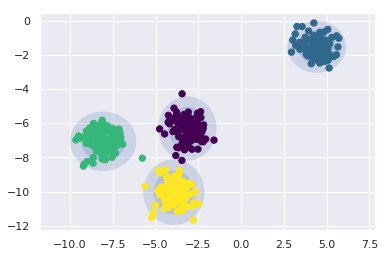

In [70]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm,X)

Perhaps, the bottom most point for the purple cluster is so uncertain because it shares the boundary with the yellow cluster. But the green one is more certain perhaps cause its closer to the boundary than the others, even if ever so slightly, and not infringing any other cluster's boundary. 

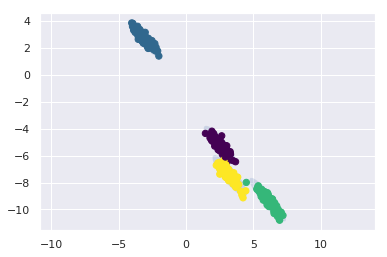

In [71]:
gmm = GMM(n_components = 4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Can see the elliptical probability boundaries if we look closely! 

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the `covariance_type` option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. 

The default is `covariance_type="diag"`, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. 

A simpler one is `covariance_type="spherical"` that results in something similar to the kmeans clustering, although not entirely equivalent, where the dimensions of the cluster is equal.

A more complicated and computationally expensive model (especially with greater dimesnions) is to use the `covariance_type="full"`, which allows clusters to be modeled as ellipses with arbitary orientation. (Not constrained to the orientation of the axes)

## GMM as *Density Estimation* 

Though often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*. 

The result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the ditribution of the data.  

Let's try this on Sci-Kit Learn's `make_moons` function

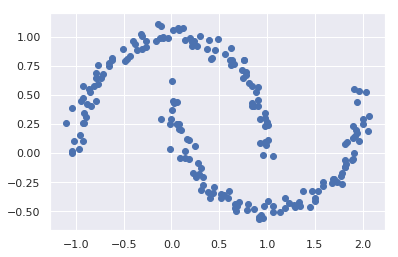

In [72]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state = 42)
plt.scatter(Xmoon[:,0], Xmoon[:,1]);

Fitting this with a 2 component GMM i.e. a clustering model results in:

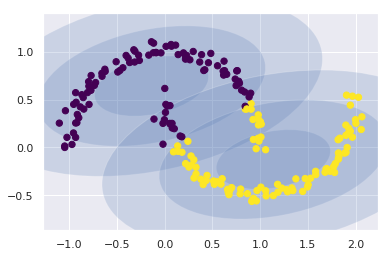

In [73]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=42)
plot_gmm(gmm2, Xmoon)

Clearly doesn't do a good job of separating two obviously different sets

However, if we instead use more components and ignore cluster labels

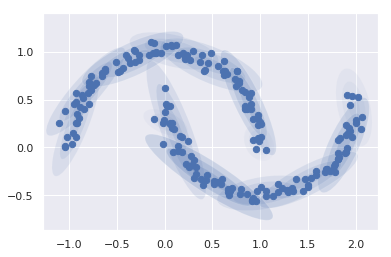

In [74]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=42)
plot_gmm(gmm16, Xmoon, label=False)

The 16 different Gaussians here aren't used to find separate clusters of data, but rather to model the overall *distribution* of the input data. 

This is a generative model of the distribution, meaning that the GMM gives us the ability to generate new random data distributed similarly to our input. 

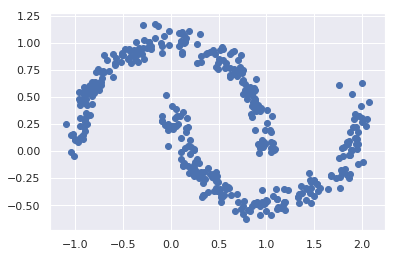

In [75]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:,0], Xnew[:,1]);

**GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.**

### Components of the data

GMM being a generative model gives us a natural way of determining the optimal number of components for a given dataset. 

A generative model is inherently a probability distribution for the dataset. This allows us to simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting. 

A couple other approaches to correct over-fitting is to adjust the model likelihoods using analytic criteria such as the Akaike information criterion and Bayesian information criteria. 

Scikit-Learn's GMM estimator includes built-in methods that compute both of these. Examining the AIC and BIC as a function of the number of GMM components on the moon dataset:


Text(0.5,0,'n_components')

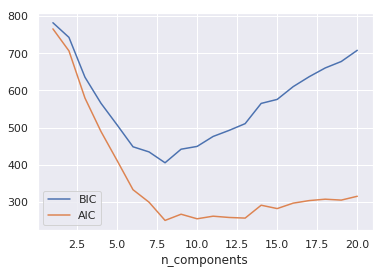

In [76]:
n_components = np.arange(1,21)

models = [GMM(n, covariance_type="full",random_state=42).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')

plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components')

The optimal number of clusters is the value that minimizes either AIC or BIC. Here we find out that **8** was perhaps the best number of clusters to use for our data instead of 16. 